# Comparison of GNN results with GNN trained using transfer learning

1. Compare results of best model from hyperparameter tuning with GNN using transfer learning for AbAg-affinity test set and AB-benchmark

2. Check how robust GNN ist on 4-Fold Cross Validation

In [86]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from abag_affinity.utils.config import read_config, get_data_paths
from pathlib import Path
from scipy.stats import norm
import seaborn as sns

In [87]:
project_root = "../.." #"." #"../.."
plot_path = os.path.join(project_root, "results", "experiments", "TF_comparison_cv")
Path(plot_path).mkdir(exist_ok=True, parents=True)

col_mapping = {
    "prediction": "gnn_prediction",
    "labels": "-log(Kd)_labels"
}

gnn_abag_test_result_path = os.path.join(project_root, "results/predictions/CV_experiment/abag_affinity_test_cv{}.csv")
gnn_ab_benchmark_result_path = os.path.join(project_root, "results/predictions/CV_experiment/benchmark_cv{}.csv")


tf_gnn_abag_test_result_path = os.path.join(project_root, "results/predictions/CV_experiment_transfer_learning/abag_affinity_test_cv{}.csv")
tf_gnn_ab_benchmark_result_path = os.path.join(project_root, "results/predictions/CV_experiment_transfer_learning/benchmark_cv{}.csv")

In [164]:
num_splits = 10

gnn_cv_results = {}
split_pdbs = {}

tf_gnn_cv_results = {}
tf_split_pdbs = {}

validation_sets = []
benchmark_sets = []

for i in range(1, num_splits + 1):
    gnn_cv_results[i] = {}
    
    gnn_cv_results[i]["abag_validation"] = pd.read_csv(gnn_abag_test_result_path.format(str(i)), index_col=0).set_index("pdb").rename(col_mapping, axis=1)
    split_pdbs[i] = gnn_cv_results[i]["abag_validation"].index.values.tolist()
    
    gnn_cv_results[i]["benchmark"] = pd.read_csv(gnn_ab_benchmark_result_path.format(str(i)), index_col=0).set_index("pdb").rename(col_mapping, axis=1)


    tf_gnn_cv_results[i] = {}

    tf_gnn_cv_results[i]["abag_validation"] = pd.read_csv(tf_gnn_abag_test_result_path.format(str(i)), index_col=0).set_index("pdb").rename(col_mapping, axis=1)
    tf_split_pdbs[i] = tf_gnn_cv_results[i]["abag_validation"].index.values.tolist()

    tf_gnn_cv_results[i]["benchmark"] = pd.read_csv(tf_gnn_ab_benchmark_result_path.format(str(i)), index_col=0).set_index("pdb").rename(col_mapping, axis=1)

    val_set = tf_gnn_cv_results[i]["abag_validation"].copy()
    val_set["Validation Set during Training"] = i
    validation_sets.append(val_set)

    val_set = tf_gnn_cv_results[i]["benchmark"].copy()
    val_set["Validation Set during Training"] = i
    benchmark_sets.append(val_set)



In [165]:
all_predictions = pd.concat(validation_sets, axis=0)
all_benchmark_predictions = pd.concat(benchmark_sets, axis=0)

In [135]:
assert split_pdbs == tf_split_pdbs

In [136]:
from sklearn.metrics import mean_squared_error
all_gnn_predictions = []
all_labels = []

all_gnn_rmse = []
all_gnn_pearson_r = []

tf_all_gnn_predictions = []
tf_all_labels = []

tf_all_gnn_rmse = []
tf_all_gnn_pearson_r = []

errors = []

for i in range(1, num_splits + 1):
    predictions = gnn_cv_results[i]["abag_validation"]["gnn_prediction"].tolist()
    labels = gnn_cv_results[i]["abag_validation"]["-log(Kd)_labels"].tolist()
    
    all_gnn_predictions.extend(predictions)
    all_labels.extend(labels)

    val_rmse = mean_squared_error(labels, predictions, squared=False)
    val_pearson = stats.pearsonr(labels, predictions)[0]

    errors.append(np.abs(np.array(predictions) - np.array(labels)))

    all_gnn_rmse.append(val_rmse)
    all_gnn_pearson_r.append(val_pearson)


    tf_predictions = tf_gnn_cv_results[i]["abag_validation"]["gnn_prediction"].tolist()
    tf_labels = tf_gnn_cv_results[i]["abag_validation"]["-log(Kd)_labels"].tolist()

    tf_all_gnn_predictions.extend(tf_predictions)
    tf_all_labels.extend(tf_labels)

    tf_val_rmse = mean_squared_error(tf_labels, tf_predictions, squared=False)
    tf_val_pearson = stats.pearsonr(tf_labels, tf_predictions)[0]

    errors.append(np.abs(np.array(tf_predictions) - np.array(tf_labels)))

    tf_all_gnn_rmse.append(tf_val_rmse)
    tf_all_gnn_pearson_r.append(tf_val_pearson)




    print(f"Split {i}: \n\t "
          f"GNN: RMSE={round(val_rmse, 3)}, R={round(val_pearson,3)}\n\t "
          f"TF-GNN: RMSE={round(tf_val_rmse, 3)}, R={round(tf_val_pearson,3)}")

val_rmse = mean_squared_error(all_labels, all_gnn_predictions)
val_pearson = stats.pearsonr(all_labels, all_gnn_predictions)[0]

tf_val_rmse = mean_squared_error(tf_all_labels, tf_all_gnn_predictions)
tf_val_pearson = stats.pearsonr(tf_all_labels, tf_all_gnn_predictions)[0]

print(f"\nFull dataset: \n\t"
      f"GNN: RMSE={round(val_rmse, 3)}, R={round(val_pearson,3)}\n\t"
      f"TF-GNN: RMSE={round(tf_val_rmse, 3)}, R={round(tf_val_pearson,3)}\n\t")

Split 1: 
	 GNN: RMSE=1.433, R=0.324
	 TF-GNN: RMSE=1.548, R=0.307
Split 2: 
	 GNN: RMSE=1.529, R=0.395
	 TF-GNN: RMSE=1.667, R=0.088
Split 3: 
	 GNN: RMSE=1.265, R=0.431
	 TF-GNN: RMSE=1.374, R=0.197
Split 4: 
	 GNN: RMSE=0.957, R=0.345
	 TF-GNN: RMSE=1.046, R=-0.032
Split 5: 
	 GNN: RMSE=1.308, R=0.351
	 TF-GNN: RMSE=1.363, R=0.263
Split 6: 
	 GNN: RMSE=1.435, R=0.203
	 TF-GNN: RMSE=1.397, R=0.384
Split 7: 
	 GNN: RMSE=1.646, R=0.377
	 TF-GNN: RMSE=1.827, R=0.045
Split 8: 
	 GNN: RMSE=0.907, R=0.572
	 TF-GNN: RMSE=1.101, R=-0.015
Split 9: 
	 GNN: RMSE=1.455, R=0.442
	 TF-GNN: RMSE=1.244, R=0.646
Split 10: 
	 GNN: RMSE=1.379, R=0.064
	 TF-GNN: RMSE=1.334, R=0.461

Full dataset: 
	GNN: RMSE=1.824, R=0.367
	TF-GNN: RMSE=1.982, R=0.318
	


## Absolute Error Comparison

In [137]:
abag_resuts_df = pd.DataFrame({"-log(Kd)_labels": all_labels, "gnn_prediction": all_gnn_predictions, "tf_gnn_prediction": tf_all_gnn_predictions})

In [138]:
abag_resuts_df["gnn_diff"] = abag_resuts_df["gnn_prediction"] - abag_resuts_df["-log(Kd)_labels"]
abag_resuts_df["gnn_error"] = np.abs(abag_resuts_df["gnn_diff"])

In [139]:
abag_resuts_df["tf_gnn_diff"] = abag_resuts_df["tf_gnn_prediction"] - abag_resuts_df["-log(Kd)_labels"]
abag_resuts_df["tf_gnn_error"] = np.abs(abag_resuts_df["tf_gnn_diff"])

In [140]:
abag_resuts_df["error_diff"] = abag_resuts_df["gnn_error"] - abag_resuts_df["tf_gnn_error"]

abag_resuts_df.describe()

,-log(Kd)_labels,gnn_prediction,tf_gnn_prediction,gnn_diff,gnn_error,tf_gnn_diff,tf_gnn_error,error_diff
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000
mean,8.165188,8.131629,8.015761,-0.033559,1.035766,-0.149427,1.058587,-0.022822
std,1.450574,0.611048,0.733035,1.351819,0.867720,1.401589,0.929147,0.765107
min,3.795880,6.253500,5.165664,-4.070697,0.002546,-4.251967,0.003262,-2.333478
25%,7.193820,7.833443,7.828622,-0.897323,0.320635,-0.937179,0.309853,-0.455892
50%,8.102373,8.262432,7.968863,0.034326,0.822716,-0.116647,0.818545,-0.078560
75%,9.094204,8.563451,8.264278,0.771324,1.514744,0.657946,1.550822,0.425192
max,11.769551,9.919485,11.233230,4.854628,4.854628,4.887757,4.887757,2.768545


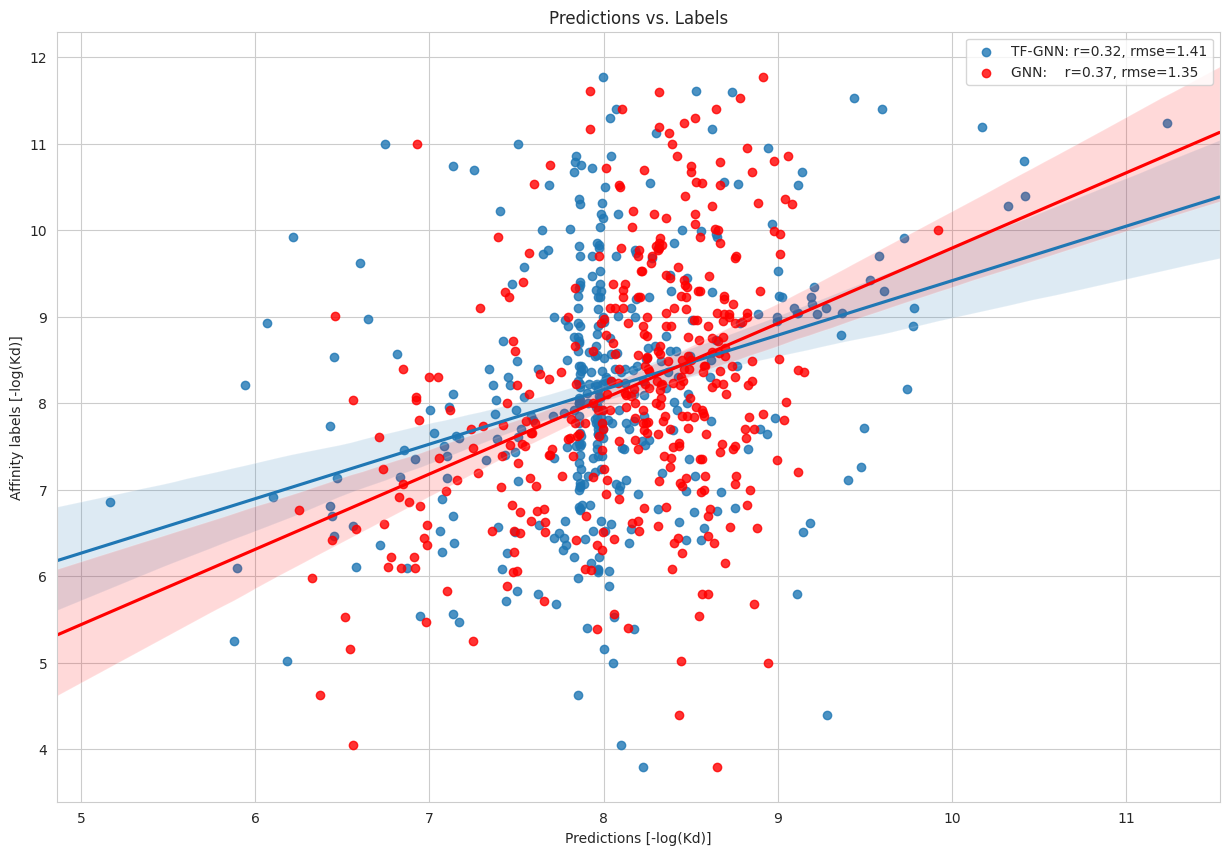

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))


legend = "TF-GNN: "
r, p = stats.pearsonr(x=abag_resuts_df["tf_gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((abag_resuts_df["tf_gnn_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)

sns.regplot(data=abag_resuts_df, x="tf_gnn_prediction",y="-log(Kd)_labels", ax=ax, truncate=False, label=legend)


legend = "GNN:    "
r, p = stats.pearsonr(x=abag_resuts_df["gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((abag_resuts_df["gnn_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)
sns.regplot(data=abag_resuts_df, x="gnn_prediction", y="-log(Kd)_labels", ax=ax, color="red", truncate=False, label=legend)

ax.set_title("Predictions vs. Labels")
ax.set_xlabel("Predictions [-log(Kd)]")
ax.set_ylabel("Affinity labels [-log(Kd)]")

ax.legend()

plt.savefig(os.path.join(plot_path, "abag_full_comparison_scatter.png"))
plt.show()
plt.close()

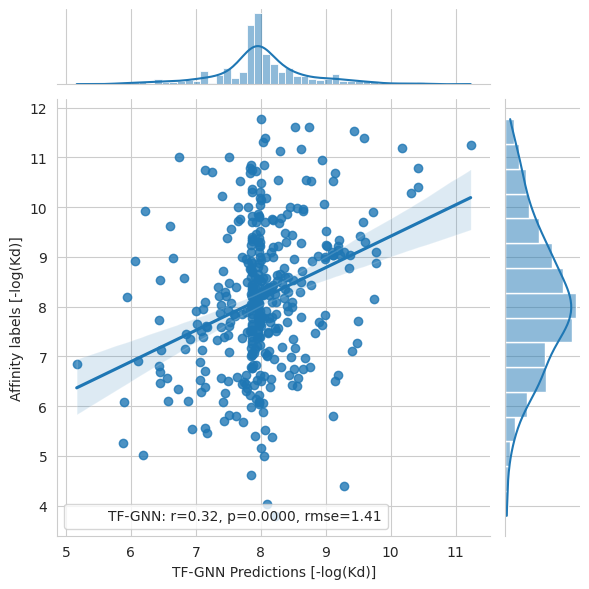

In [142]:
legend = "TF-GNN: "
r, p = stats.pearsonr(x=abag_resuts_df["tf_gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((abag_resuts_df["tf_gnn_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)

plot = sns.jointplot(x=abag_resuts_df["tf_gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values, kind="reg")

plot.ax_joint.set_xlabel("TF-GNN Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()

plt.savefig(os.path.join(plot_path, "tf_gnn_abag_corr_plot.png"))
plt.show()
plt.close()

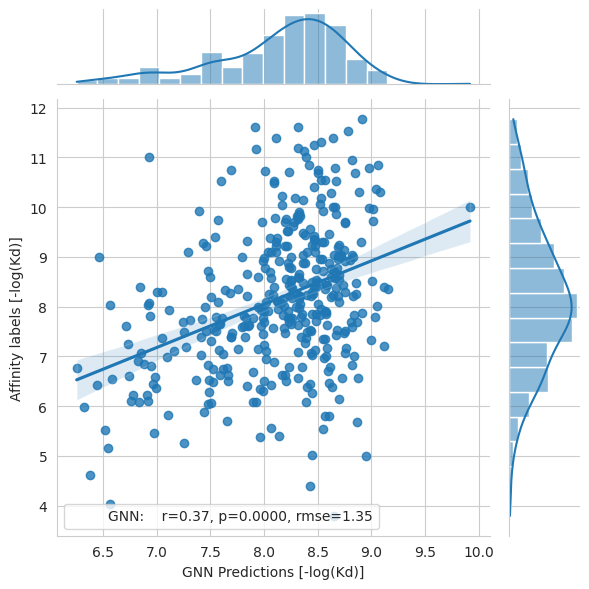

In [143]:

legend = "GNN:    "
r, p = stats.pearsonr(x=abag_resuts_df["gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((abag_resuts_df["gnn_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)
plot = sns.jointplot(x=abag_resuts_df["gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values, kind="reg")

plot.ax_joint.set_xlabel("GNN Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()
plt.savefig(os.path.join(plot_path, "gnn_abag_corr_plot.png"))
plt.show()
plt.close()

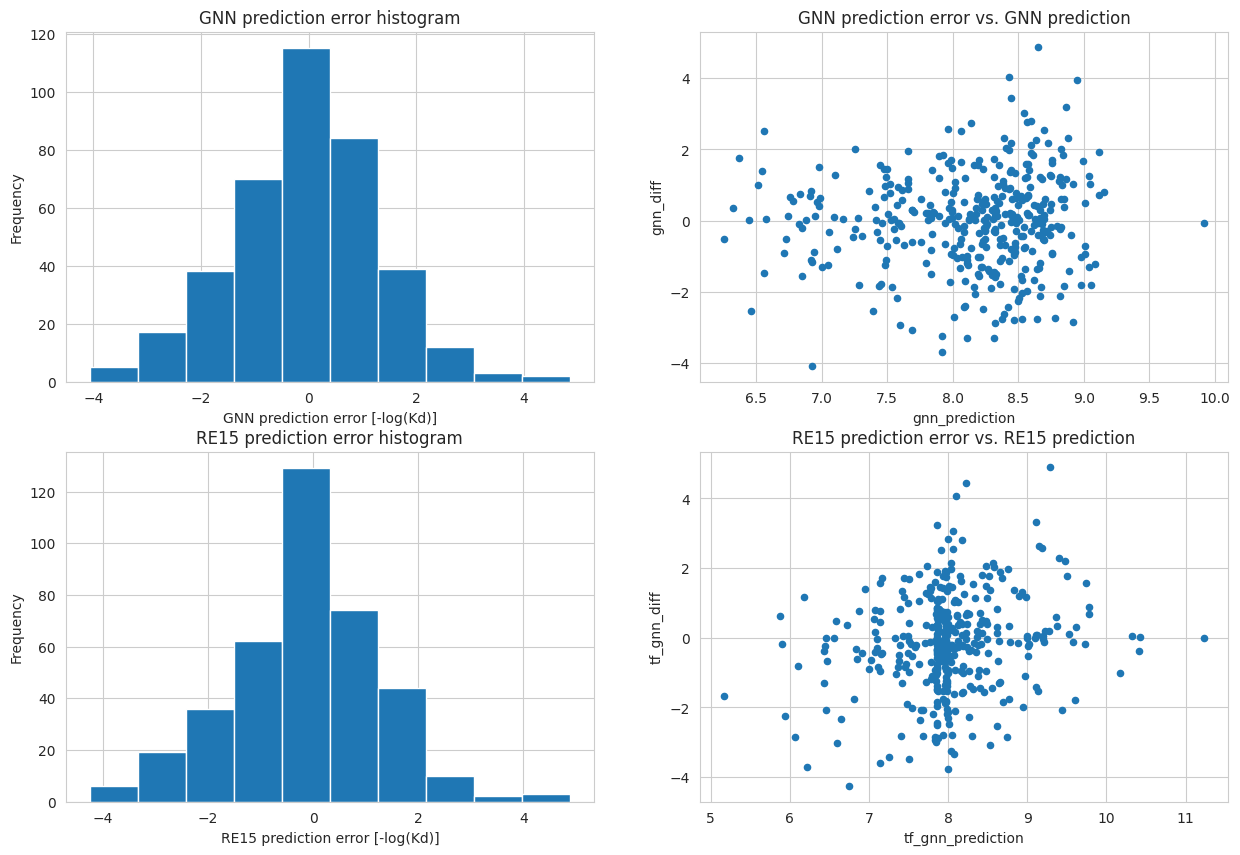

In [144]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

abag_resuts_df["gnn_diff"].plot.hist(ax=ax[0,0])
ax[0,0].set_title("GNN prediction error histogram")
ax[0,0].set_xlabel("GNN prediction error [-log(Kd)]")

abag_resuts_df.plot.scatter("gnn_prediction", "gnn_diff", ax=ax[0,1])
ax[0,1].set_title("GNN prediction error vs. GNN prediction")

abag_resuts_df["tf_gnn_diff"].plot.hist(ax=ax[1,0])
ax[1,0].set_title("RE15 prediction error histogram")
ax[1,0].set_xlabel("RE15 prediction error [-log(Kd)]")

abag_resuts_df[abag_resuts_df["tf_gnn_prediction"] > 0].plot.scatter("tf_gnn_prediction", "tf_gnn_diff", ax=ax[1,1])
ax[1,1].set_title("RE15 prediction error vs. RE15 prediction")

plt.savefig(os.path.join(plot_path, "abag_error_distributions.png"))
plt.show()
plt.close()

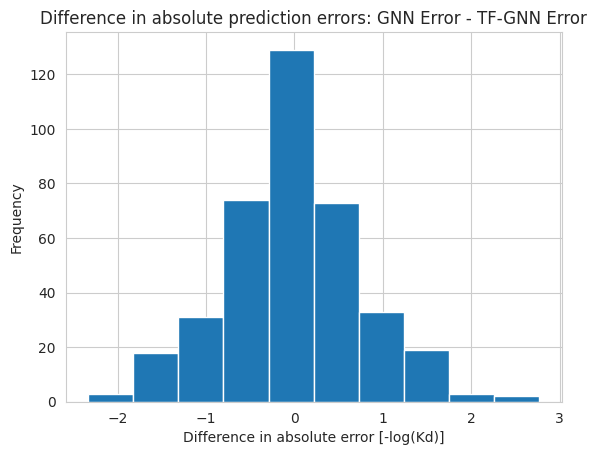

In [167]:
abag_resuts_df["error_diff"].plot.hist()
plt.title("Difference in absolute prediction errors: GNN Error - TF-GNN Error")
plt.xlabel("Difference in absolute error [-log(Kd)]")
plt.savefig(os.path.join(plot_path, "tf_abag_error_difference_distributions.png"))
plt.show()
plt.close()

In [146]:
stats.wilcoxon(abag_resuts_df["gnn_error"], abag_resuts_df["tf_gnn_error"], alternative="less")

WilcoxonResult(statistic=35014.0, pvalue=0.16385627427132293)

In [147]:
abag_resuts_df["gnn_error"].describe()

count    385.000000
mean       1.035766
std        0.867720
min        0.002546
25%        0.320635
50%        0.822716
75%        1.514744
max        4.854628
Name: gnn_error, dtype: float64

In [148]:
abag_resuts_df["tf_gnn_error"].describe()

count    385.000000
mean       1.058587
std        0.929147
min        0.003262
25%        0.309853
50%        0.818545
75%        1.550822
max        4.887757
Name: tf_gnn_error, dtype: float64

## RSME Comparison

In [149]:
abag_resulst_cv = pd.DataFrame({"gnn_rmse":all_gnn_rmse, "tf_gnn_rmse": tf_all_gnn_rmse, "gnn_pearson": all_gnn_pearson_r, "tf_gnn_pearson": tf_all_gnn_pearson_r})
abag_resulst_cv["rmse_diff"] = abag_resulst_cv["gnn_rmse"] - abag_resulst_cv["tf_gnn_rmse"]
abag_resulst_cv["pearson_diff"] = abag_resulst_cv["gnn_pearson"] - abag_resulst_cv["tf_gnn_pearson"]

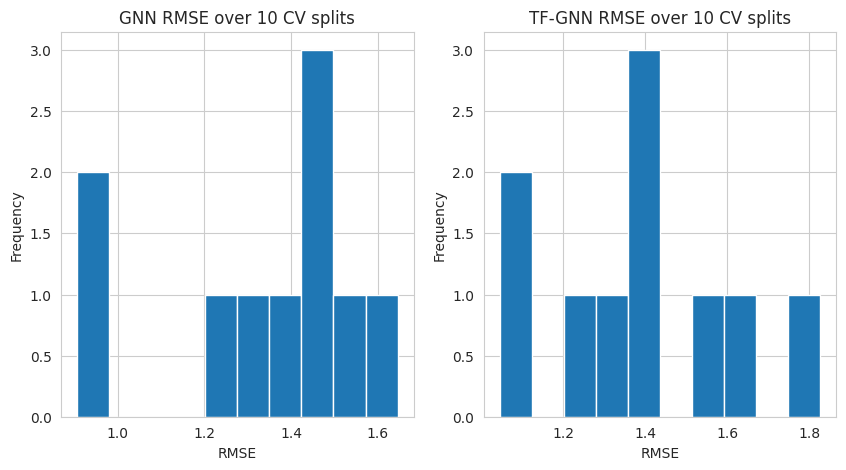

In [150]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

abag_resulst_cv["gnn_rmse"].plot.hist(ax=ax[0])
ax[0].set_title("GNN RMSE over 10 CV splits")
ax[0].set_xlabel("RMSE")

abag_resulst_cv["tf_gnn_rmse"].plot.hist(ax=ax[1])
ax[1].set_title("TF-GNN RMSE over 10 CV splits")
ax[1].set_xlabel("RMSE")


plt.savefig(os.path.join(plot_path, "RMSE_CV_comparison.png"))
plt.show()
plt.close()

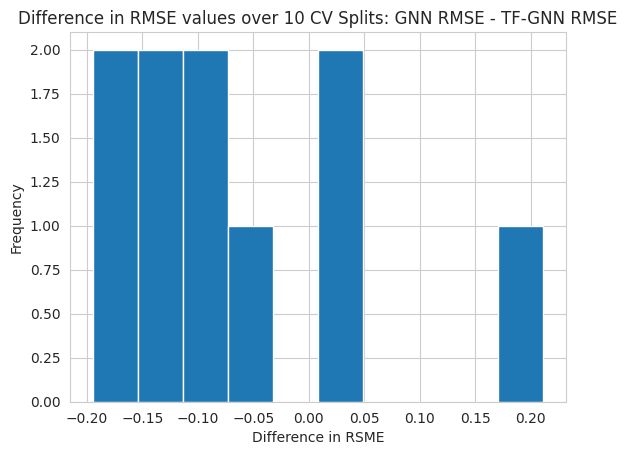

In [151]:
abag_resulst_cv["rmse_diff"].plot.hist()
plt.title("Difference in RMSE values over 10 CV Splits: GNN RMSE - TF-GNN RMSE")
plt.xlabel("Difference in RSME")
plt.savefig(os.path.join(plot_path, "abag_rsme_difference_distributions.png"))
plt.show()
plt.close()

In [152]:
stats.wilcoxon(abag_resulst_cv["gnn_rmse"], abag_resulst_cv["tf_gnn_rmse"], alternative="less")

WilcoxonResult(statistic=13.0, pvalue=0.080078125)

In [153]:
abag_resulst_cv["gnn_rmse"].describe()

count    10.000000
mean      1.331379
std       0.236197
min       0.906641
25%       1.275535
50%       1.405781
75%       1.450399
max       1.645990
Name: gnn_rmse, dtype: float64

In [154]:
abag_resulst_cv["tf_gnn_rmse"].describe()

count    10.000000
mean      1.390083
std       0.240405
min       1.045768
25%       1.266417
50%       1.368418
75%       1.510167
max       1.827489
Name: tf_gnn_rmse, dtype: float64

## Pearson Correlation Comparison

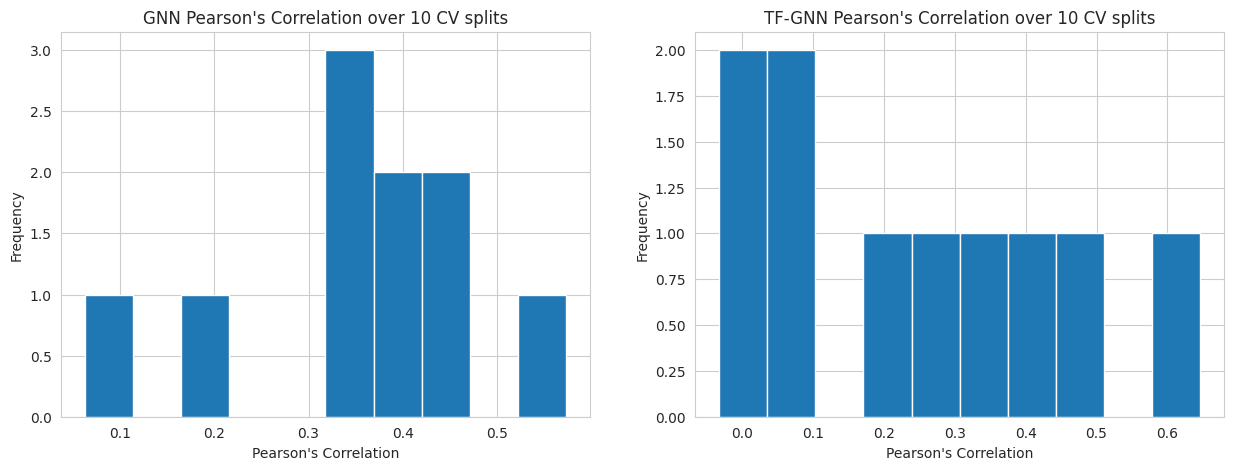

In [155]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

abag_resulst_cv["gnn_pearson"].plot.hist(ax=ax[0])
ax[0].set_title("GNN Pearson's Correlation over 10 CV splits")
ax[0].set_xlabel("Pearson's Correlation")

abag_resulst_cv["tf_gnn_pearson"].plot.hist(ax=ax[1])
ax[1].set_title("TF-GNN Pearson's Correlation over 10 CV splits")
ax[1].set_xlabel("Pearson's Correlation")


plt.savefig(os.path.join(plot_path, "Pearson_R_CV_comparison.png"))
plt.show()
plt.close()

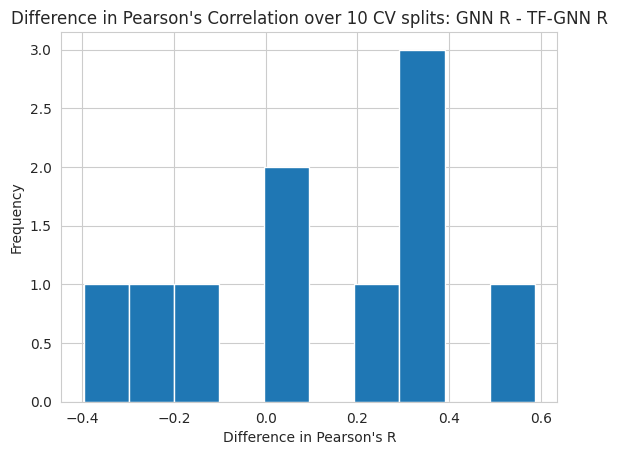

In [156]:
abag_resulst_cv["pearson_diff"].plot.hist()
plt.title("Difference in Pearson's Correlation over 10 CV splits: GNN R - TF-GNN R")
plt.xlabel("Difference in Pearson's R")
plt.savefig(os.path.join(plot_path, "abag_pearson_difference_distributions.png"))
plt.show()
plt.close()

In [157]:
stats.wilcoxon(abag_resulst_cv["gnn_pearson"], abag_resulst_cv["tf_gnn_pearson"], alternative="greater")

WilcoxonResult(statistic=39.0, pvalue=0.1376953125)

In [158]:
abag_resulst_cv["gnn_pearson"].describe()

count    10.000000
mean      0.350241
std       0.138038
min       0.063595
25%       0.328944
50%       0.363781
75%       0.422219
max       0.572244
Name: gnn_pearson, dtype: float64

In [159]:
abag_resulst_cv["tf_gnn_pearson"].describe()

count    10.000000
mean      0.234373
std       0.221196
min      -0.032253
25%       0.056055
50%       0.229829
75%       0.364681
max       0.645708
Name: tf_gnn_pearson, dtype: float64

### Absolute error comparison between validation splits

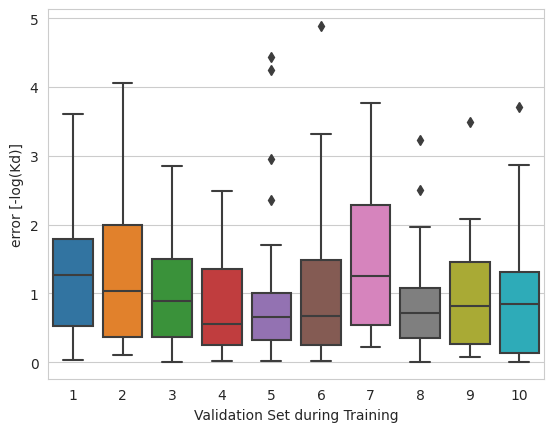

In [163]:
all_predictions["error [-log(Kd)]"] = np.abs(all_predictions["gnn_prediction"] - all_predictions["-log(Kd)_labels"])
sns.boxplot(data=all_predictions, y="error [-log(Kd)]", x="Validation Set during Training")
plt.savefig(os.path.join(plot_path, "tf_validation_errors_for_cv.png"))

## AB-benchmark

In [114]:
benchmark_gnn_results = gnn_cv_results[1]["benchmark"]
all_benchmark_labels = benchmark_gnn_results["-log(Kd)_labels"]
all_benchmark_gnn_predictions = benchmark_gnn_results["gnn_prediction"]

In [115]:
benchmark_tf_gnn_results = tf_gnn_cv_results[1]["benchmark"]
all_benchmark_tf_gnn_predictions = benchmark_tf_gnn_results["gnn_prediction"]

In [116]:
gnn_benchmark_rmse = mean_squared_error(all_benchmark_labels, all_benchmark_gnn_predictions, squared=False)
gnn_benchmark_pearson, gnn_pearson_p_value = stats.pearsonr(all_benchmark_labels, all_benchmark_gnn_predictions)
gnn_benchmark_mae = np.mean(np.abs(all_benchmark_labels - all_benchmark_gnn_predictions))

In [117]:
tf_gnn_benchmark_rmse = mean_squared_error(all_benchmark_labels, all_benchmark_tf_gnn_predictions, squared=False)
tf_gnn_benchmark_pearson, tf_gnn_pearson_p_value  = stats.pearsonr(all_benchmark_labels, all_benchmark_tf_gnn_predictions)
tf_gnn_benchmark_mae = np.mean(np.abs(all_benchmark_labels - all_benchmark_tf_gnn_predictions))


In [118]:
print(f"Benchmark RMSE >>> GNN={round(gnn_benchmark_rmse, 2)}, TF-GNN={round(tf_gnn_benchmark_rmse, 2)}")
print(f"Benchmark Pearson's R >>> GNN={round(gnn_benchmark_pearson, 2)}({gnn_pearson_p_value}), TF-GNN={round(tf_gnn_benchmark_pearson, 2)}({tf_gnn_pearson_p_value})")
print(f"Benchmark MAE >>> GNN={round(gnn_benchmark_mae, 2)}, TF-GNN={round(tf_gnn_benchmark_mae, 2)}")

Benchmark RMSE >>> GNN=1.43, TF-GNN=1.89
Benchmark Pearson's R >>> GNN=0.37(0.01651233602720025), TF-GNN=-0.19(0.2389018425074162)
Benchmark MAE >>> GNN=1.19, TF-GNN=1.59


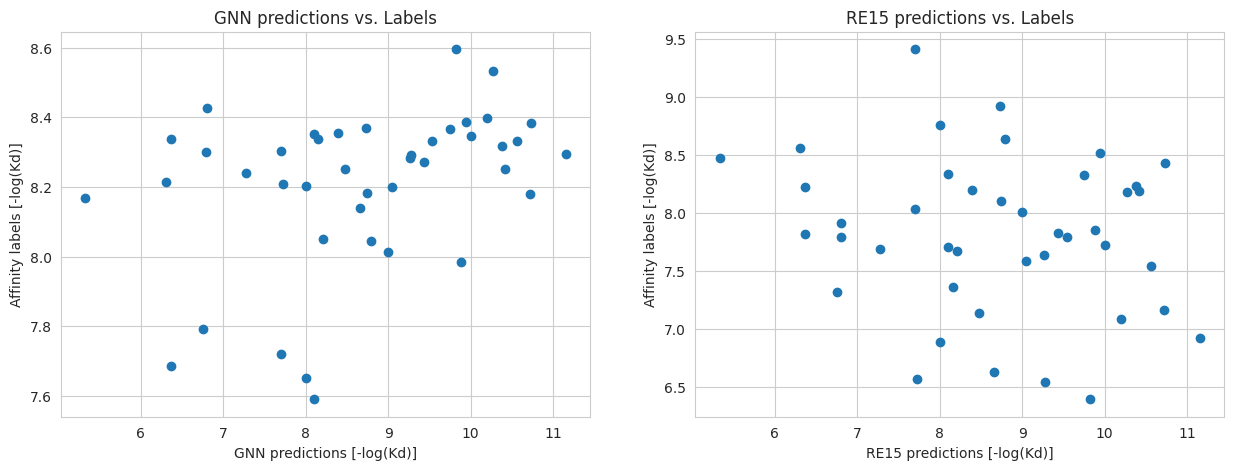

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(all_benchmark_labels, all_benchmark_gnn_predictions)
ax[0].set_title("GNN predictions vs. Labels")
ax[0].set_xlabel("GNN predictions [-log(Kd)]")
ax[0].set_ylabel("Affinity labels [-log(Kd)]")

ax[1].scatter(all_benchmark_labels, all_benchmark_tf_gnn_predictions)
ax[1].set_title("RE15 predictions vs. Labels")
ax[1].set_xlabel("RE15 predictions [-log(Kd)]")
ax[1].set_ylabel("Affinity labels [-log(Kd)]")

plt.savefig(os.path.join(plot_path, "benchmark_preds_vs_labels.png"))
plt.show()
plt.close()

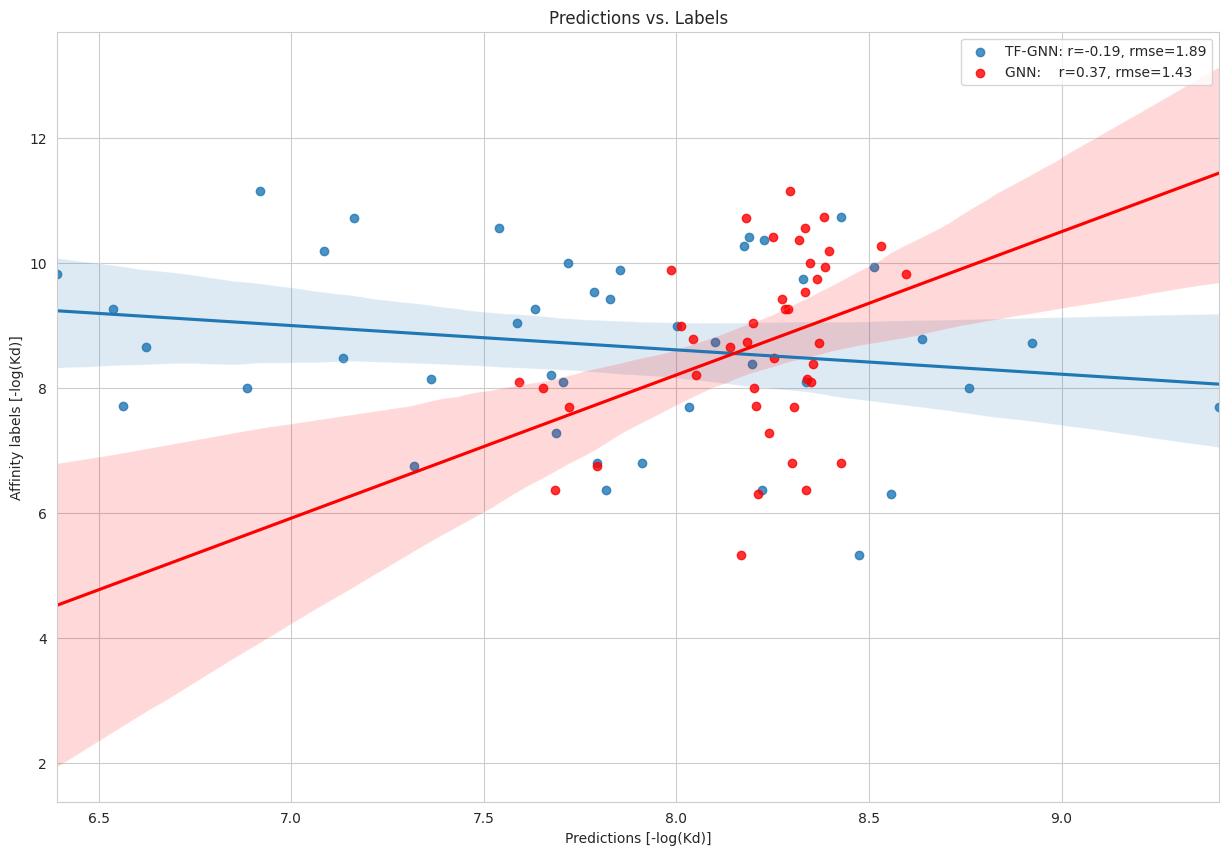

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_xlim(np.min((all_benchmark_tf_gnn_predictions.min(), all_benchmark_gnn_predictions.min())),
         np.max((all_benchmark_tf_gnn_predictions.max(), all_benchmark_gnn_predictions.max())))


legend = "TF-GNN: "
r, p = stats.pearsonr(x=all_benchmark_tf_gnn_predictions.values, y=all_benchmark_labels)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((all_benchmark_tf_gnn_predictions.values-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)

sns.regplot( x=all_benchmark_tf_gnn_predictions,y=all_benchmark_labels, ax=ax, truncate=False, label=legend)


legend = "GNN:    "
r, p = stats.pearsonr(x=all_benchmark_gnn_predictions, y=all_benchmark_labels.values)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((all_benchmark_gnn_predictions.values-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)
sns.regplot(x=all_benchmark_gnn_predictions, y=all_benchmark_labels, ax=ax, color="red", truncate=False, label=legend)

ax.set_title("Predictions vs. Labels")
ax.set_xlabel("Predictions [-log(Kd)]")
ax.set_ylabel("Affinity labels [-log(Kd)]")

ax.legend()

plt.savefig(os.path.join(plot_path, "benchmark_full_comparison_scatter.png"))
plt.show()
plt.close()

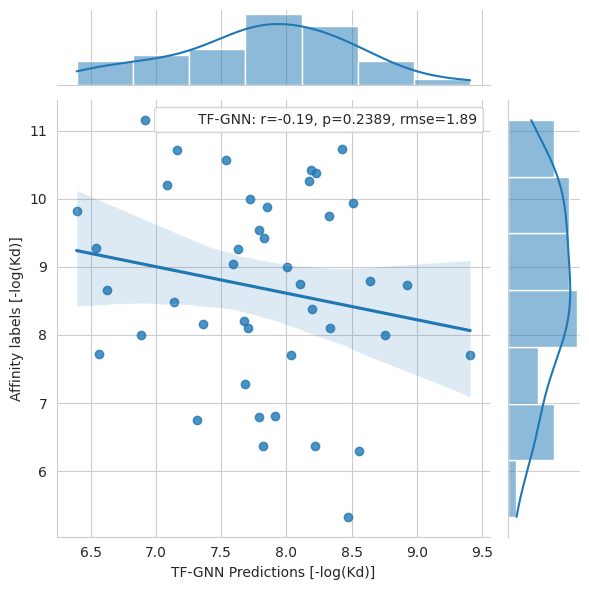

In [121]:
legend = "TF-GNN: "
r, p = stats.pearsonr(x=all_benchmark_tf_gnn_predictions, y=all_benchmark_labels)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((all_benchmark_tf_gnn_predictions-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)

plot = sns.jointplot(x=all_benchmark_tf_gnn_predictions, y=all_benchmark_labels, kind="reg")

plot.ax_joint.set_xlabel("TF-GNN Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()

plt.savefig(os.path.join(plot_path, "tf_gnn_behchmark_corr_plot.png"))
plt.show()
plt.close()

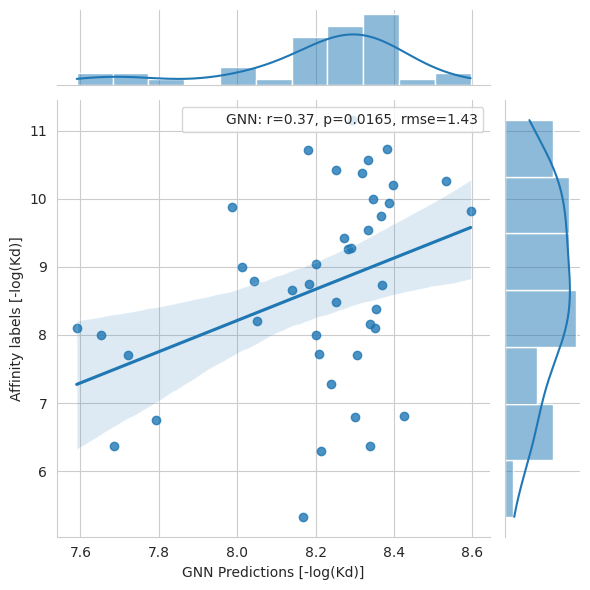

In [122]:
legend = "GNN: "
r, p = stats.pearsonr(x=all_benchmark_gnn_predictions, y=all_benchmark_labels)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((all_benchmark_gnn_predictions-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)

plot = sns.jointplot(x=all_benchmark_gnn_predictions, y=all_benchmark_labels, kind="reg")

plot.ax_joint.set_xlabel("GNN Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()

plt.savefig(os.path.join(plot_path, "gnn_behchmark_corr_plot.png"))
plt.show()
plt.close()

In [123]:
stats.wilcoxon(np.abs(all_benchmark_tf_gnn_predictions-all_benchmark_labels), np.abs(all_benchmark_gnn_predictions-all_benchmark_labels))

WilcoxonResult(statistic=187.0, pvalue=0.0009422717677877023)

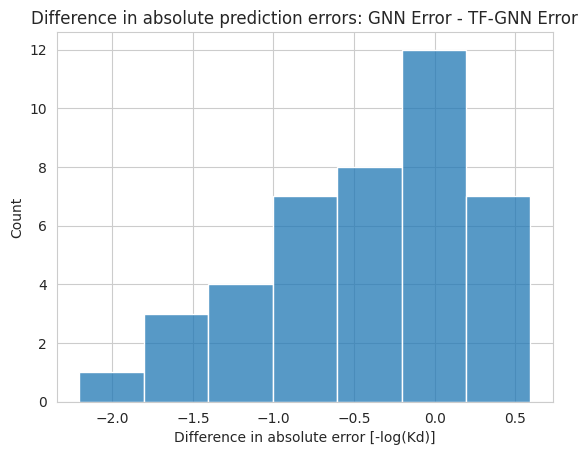

In [124]:
benchmark_error_diff = np.abs(all_benchmark_gnn_predictions-all_benchmark_labels) - np.abs(all_benchmark_tf_gnn_predictions-all_benchmark_labels)
sns.histplot(benchmark_error_diff)

plt.title("Difference in absolute prediction errors: GNN Error - TF-GNN Error")
plt.xlabel("Difference in absolute error [-log(Kd)]")
plt.savefig(os.path.join(plot_path, "benchmark_error_difference_distributions.png"))
plt.show()
plt.close()

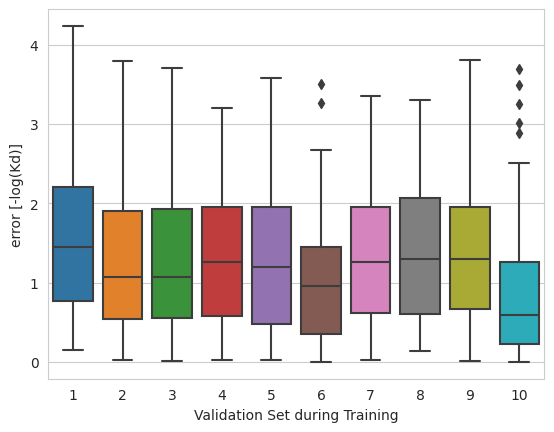

In [166]:
all_benchmark_predictions["error [-log(Kd)]"] = np.abs(all_benchmark_predictions["gnn_prediction"] - all_benchmark_predictions["-log(Kd)_labels"])
sns.boxplot(data=all_benchmark_predictions, y="error [-log(Kd)]", x="Validation Set during Training")
plt.savefig(os.path.join(plot_path, "tf_benchmark_errors_for_cv.png"))